# Lesson 6 - Scalar Regression

In [ ]:
#hide
#Run once per session
!pip install fastai wwf -q --upgrade

     |████████████████████████████████| 194kB 10.0MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


In [ ]:
#hide_input
from wwf.utils import state_versions
state_versions(['fastai', 'fastcore', 'wwf'])


---
This article is also a Jupyter Notebook available to be run from the top down. There
will be code snippets that you can then run in any environment.

Below are the versions of `fastai`, `fastcore`, and `wwf` currently running at the time of writing this:
* `fastai`: 2.1.10 
* `fastcore`: 1.3.13 
* `wwf`: 0.0.7 
---

This notebook describes how to perform Scalar regression on images 

## Importing the library

Today will be a vision based task:

In [ ]:
from fastai.vision.all import *

Below you will find the exact imports for everything we use today

In [ ]:
from fastcore.basics import Int
from fastcore.transform import DisplayedTransform
from fastcore.xtras import Path

from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import fine_tune

from fastai.data.block import DataBlock, RegressionBlock
from fastai.data.transforms import RandomSplitter, get_image_files, ColReader

from fastai.losses import MSELossFlat

from fastai.torch_core import ShowTitle, show_title, TitledFloat

from fastai.vision.augment import Resize, aug_transforms, Flip, Rotate, Zoom, Warp
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models.resnet import resnet50

from datetime import datetime, timedelta
import pandas as pd
from scipy.io import loadmat

import numpy as np

## Dataset

The dataset is the [IMDB-WIKI](https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/) dataset in which we try to guess the expected age from an indivudal image. We'll focus on the WIKI dataset.

In [ ]:
url = 'https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar'

In [ ]:
!wget {url}

--2020-12-31 17:06:00--  https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/wiki_crop.tar
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.162
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 811315200 (774M) [application/x-tar]
Saving to: ‘wiki_crop.tar’

wiki_crop.tar       100%[===================>] 773.73M  19.6MB/s    in 41s     

2020-12-31 17:06:42 (18.9 MB/s) - ‘wiki_crop.tar’ saved [811315200/811315200]



In [ ]:
!tar -xvf 'wiki_crop.tar'

Now the dataset itself is pretty easy, there is an included `.mat` file we can convert to Pandas. Let's go through that process:

*We are following the same preperation code as seen [here](https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/)*

* Note: the video and this notebook differ here. This is because I was labelling the data wrong intially, and the floats are now inheritly supported

In [ ]:
from scipy.io import loadmat
from datetime import datetime, timedelta

In [ ]:
def prepare_dataframe(path:Path):
    "Builds wiki_crop DataFrame based on https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/"
    mat = loadmat(path)
    instances = mat['wiki'][0][0][0].shape[1]
    columns = ['dob', 'photo_taken', 'full_path', 'gender', 'name', 'face_location', 'face_score', 'second_face_score']
    df = pd.DataFrame(index=range(0, instances), columns=columns)
    for i in mat:
        if i == 'wiki':
            curr_arr = mat[i][0][0]
            for j, val in enumerate(curr_arr):
                df[columns[j]] = pd.DataFrame(val[0])

    ### Python datatime conversion
    df['date_of_birth'] = df['dob'].apply(datenum_to_datetime)
    df['age'] = df['photo_taken'] - df['date_of_birth']

    ## Data cleaning
    df = df[df['face_score'] != -np.inf] # picture doesn't include faces
    df = df[df['second_face_score'].isna()] # more than one face
    df = df[df['face_score'] > 3] # has a score
    df = df[df['age'] < 100] # older than 100 (mostly paintings)
    df = df[df['age'] > 0] # unborn people
    df = df[['full_path', 'age']]
    df['full_path'] = df['full_path'].apply(lambda x: x[0])
    return df

def datenum_to_datetime(datenum):
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    exact_date = datetime.fromordinal(int(datenum)) \
    + timedelta(days=int(days)) + timedelta(hours=int(hours)) \
    + timedelta(minutes=int(minutes)) + timedelta(seconds=round(seconds)) \
    - timedelta(days=366)
    return exact_date.year

In [ ]:
path = Path('wiki_crop/wiki.mat')

In [ ]:
df = prepare_dataframe(path)

In [ ]:
df.head()

,full_path,age
0,17/10000217_1981-05-05_2009.jpg,28
2,12/100012_1948-07-03_2008.jpg,60
4,16/10002116_1971-05-31_2012.jpg,41
5,02/10002702_1960-11-09_2012.jpg,52
6,41/10003541_1937-09-27_1971.jpg,34


Let's make a `get_x` and a `get_y` since we are using a `DataFrame`

In [ ]:
get_x = ColReader('full_path', pref=Path('wiki_crop'))
get_y = ColReader('age')

In [ ]:
block = DataBlock(blocks=(ImageBlock, RegressionBlock()),
                  get_x = get_x,
                  get_y = get_y,
                  splitter=RandomSplitter(),
                  item_tfms=Resize(460, method='squish'),
                  batch_tfms=[*aug_transforms(size=224, max_warp=0)])

Let's look at a batch of data;

In [ ]:
dls = block.dataloaders(df)

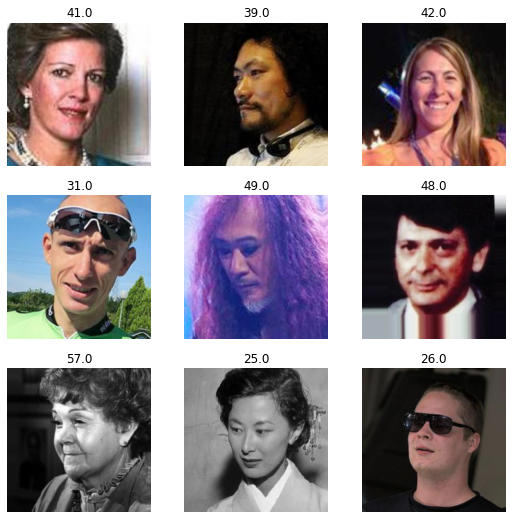

In [ ]:
dls.show_batch()

In [ ]:
dls.c

1

And now we can run this through `cnn_learner`

In [ ]:
from fastai.metrics import mae

In [ ]:
learn = cnn_learner(dls, resnet50, loss_func=MSELossFlat(), y_range=(0,100), metrics=mae)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=2.511886486900039e-05)

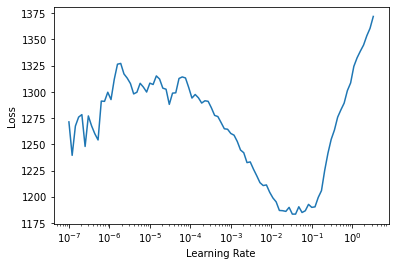

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5, 1e-2)

epoch,train_loss,valid_loss,mae,time
0,237.782486,148.187714,9.395867,02:46


epoch,train_loss,valid_loss,mae,time
0,99.831512,110.825821,8.239451,02:52
1,107.286827,84.391441,6.978492,02:50
2,75.680359,92.177994,7.369428,02:48
3,60.857635,52.496132,5.361894,02:48
4,49.180912,48.478687,5.149745,02:50
